# Evaluation

In [ ]:
import os

if "visualization" in os.getcwd():
    os.chdir("..")

if "notebooks" in os.getcwd():
    os.chdir("..")
os.getcwd()

In [2]:
from src.dataset import register_default_datasets
from src.visualization import create_confusion_matrix

import matplotlib.pyplot as plt
from pathlib import Path
import glob
import numpy as np

import detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import detection_utils as utils
from detectron2.utils.visualizer import Visualizer
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.structures.masks import polygons_to_bitmask
import copy
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import torch
import pandas as pd
import seaborn as sn

register_default_datasets()
meta_dataset = MetadataCatalog.get("train")

In [8]:
root = Path("./ouput5")
config_path = str(root / "config.yaml")
cfg = get_cfg()
cfg.merge_from_file(config_path)
cfg.MODEL.WEIGHTS = str(root / "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
predictor = DefaultPredictor(cfg)

In [9]:
def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    data = dict()

    data["height"]  = dataset_dict["height"]
    data["width"]  = dataset_dict["width"]
    data["file_name"] = dataset_dict["file_name"]
    data["image"] = image

    instances = utils.annotations_to_instances(dataset_dict["annotations"], image.shape[:2])
    data["instances"] = utils.filter_empty_instances(instances)
    
    return data

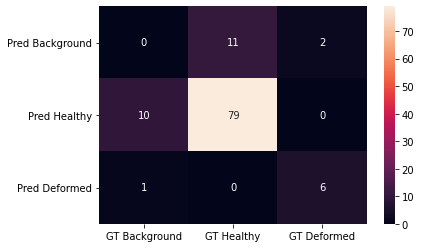

CPU times: user 37 s, sys: 665 ms, total: 37.7 s
Wall time: 4.85 s


In [10]:
%%time

dataset = DatasetCatalog.get("val")

ground_truths = []
predictions = []

for item in dataset:
    gt = mapper(item)
    pred_instances = predictor(gt["image"])["instances"].to("cpu")
    
    ground_truths.append(gt)
    predictions.append(pred_instances)

m, labels = create_confusion_matrix(ground_truths, predictions, meta_dataset)
df = pd.DataFrame(m, index=list(map(lambda x: "Pred " + x, labels)), columns=list(map(lambda x: "GT " + x, labels)))
sn.heatmap(df, annot=True)
plt.show()

In [11]:
%%time

dataset = DatasetCatalog.get("test")

ground_truths = []
predictions = []

for item in dataset:
    gt = mapper(item)
    pred_instances = predictor(gt["image"])["instances"].to("cpu")
    
    ground_truths.append(gt)
    predictions.append(pred_instances)

m, labels = create_confusion_matrix(ground_truths, predictions, meta_dataset)
df = pd.DataFrame(m, index=list(map(lambda x: "Pred " + x, labels)), columns=list(map(lambda x: "GT " + x, labels)))




CPU times: user 29.7 s, sys: 692 ms, total: 30.4 s
Wall time: 3.96 s


(504, 504, 3)

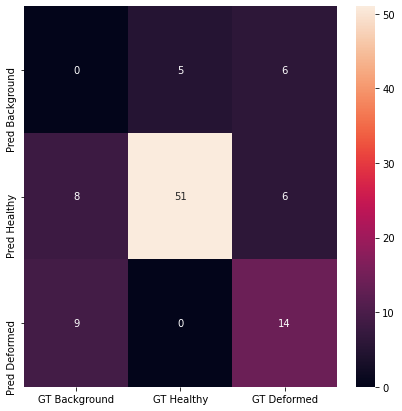

In [24]:
import io
import cv2
plt.figure(figsize=(7, 7))
sn.heatmap(df, annot=True)
buf = io.BytesIO()
plt.savefig(buf, format='jpg')
buf.seek(0)
cv2.imdecode(np.frombuffer(buf.getvalue(), np.uint8), -1)

In [16]:
??Image.frombytes

Signature: Image.frombytes(mode, size, data, decoder_name='raw', *args)
Source:   
def frombytes(mode, size, data, decoder_name="raw", *args):
    """
    Creates a copy of an image memory from pixel data in a buffer.

    In its simplest form, this function takes three arguments
    (mode, size, and unpacked pixel data).

    You can also use any pixel decoder supported by PIL.  For more
    information on available decoders, see the section
    :ref:`Writing Your Own File Decoder <file-decoders>`.

    Note that this function decodes pixel data only, not entire images.
    If you have an entire image in a string, wrap it in a
    :py:class:`~io.BytesIO` object, and use :py:func:`~PIL.Image.open` to load
    it.

    :param mode: The image mode. See: :ref:`concept-modes`.
    :param size: The image size.
    :param data: A byte buffer containing raw data for the given mode.
    :param decoder_name: What decoder to use.
    :param args: Additional parameters for the given decoder.
    